<a href="https://colab.research.google.com/github/honi-sm/AmphiBIO_TraitAnalysisFinal/blob/main/CleanedDataPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy openpyxl


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving AmphiBIOv1Raw.xlsx to AmphiBIOv1Raw.xlsx


In [ ]:
"""
AmphiBIO Data Cleaning
Author: Lia Grace Stratos
Institution: University of Nebraska Omaha
Date: November 2025

Purpose:
    Reproduces what Idid in Excel for the AmphiBIO dataset.
    It filters out incomplete or invalid entries, standardizes text and numeric
    and combines the 0 or 1 columns into categorical variables for habitat type and
    reproductive method. Then gets a seed to reproduce random sample of 500 species.

Use:
    Run this script in the same directory as AmphiBIOv1Raw.xlsx
    The output includes two CSV files:
        1. cleanDataPython.csv
        2. randomSample_500_python.csv

Expected:
    - Original dataset had 6,777 rows
    - After cleaning is about 1,481 usable species
    - All missing values ('NA', blanks, zeros) are treated consistently
"""

import pandas as pd
import numpy as np
import sys
import os

# File path
RAW_FILE = "AmphiBIOv1Raw.xlsx"
OUTPUT_CLEAN = "cleanDataPython.csv"
OUTPUT_SAMPLE = "randomSample_500_python.csv"
RANDOM_SEED = 2025


# Load dtat
def load_data(file_path: str) -> pd.DataFrame:
    """Load the raw dataset with missing value handling."""
    if not os.path.exists(file_path):
        sys.exit(f"Error: File '{file_path}' not found lol, need glasses?")
    try:
        df = pd.read_excel(
            file_path,
            engine="openpyxl",
            na_values=["NA", "N/A", "na", "NaN", "", " "]
        )
        print(f"Loaded file: {file_path} ({df.shape[0]} rows, {df.shape[1]} columns)")
        return df
    except Exception as e:
        sys.exit(f"I can't reaaaaaad '{file_path}': {e}")


# Check columns
def validate_columns(df: pd.DataFrame, required: list[str]) -> None:
    """Verify all necessary columns are present."""
    missing = [c for c in required if c not in df.columns]
    if missing:
        sys.exit(f"Error: Missing required columns: {missing}")


# trandlate the raw habitat types
def make_habitat(row: pd.Series) -> str:
    parts = []
    if row["Fos"] == 1: parts.append("fossorial")
    if row["Ter"] == 1: parts.append("terrestrial")
    if row["Aqu"] == 1: parts.append("aquatic")
    if row["Arb"] == 1: parts.append("arboreal")
    return " + ".join(parts) if parts else np.nan


# translate reproductiveMethod
def make_reproduction(row: pd.Series) -> str:
    if row["Dir"] == 1:
        return "direct"
    elif row["Lar"] == 1:
        return "larval"
    elif row["Viv"] == 1:
        return "viviparous"
    else:
        return np.nan


# export that biatch
def safe_export(df: pd.DataFrame, filename: str) -> None:
    """Write DataFrame to CSV with error handling."""
    try:
        df.to_csv(filename, index=False)
        print(f"Saved: {filename} ({len(df)} rows)")
    except PermissionError:
        print(f"Error: Permission denied while saving '{filename}'. Close any open file and retry.")
    except Exception as e:
        print(f"Unexpected error saving '{filename}': {e}")


# Loaading raw for the CSV
raw = load_data(RAW_FILE)

# Drop metadata but make note for the other sheet
drop_cols = ["id", "Order", "Family", "Genus", "OBS"]
raw = raw.drop(columns=[c for c in drop_cols if c in raw.columns])

# Keep other columns
cols = [
    "Species", "Fos", "Ter", "Aqu", "Arb",
    "Body_size_mm", "Litter_size_min_n", "Litter_size_max_n",
    "Dir", "Lar", "Viv"
]
validate_columns(raw, cols)
data = raw[cols].copy()

# Normalize text
data["Species"] = (
    data["Species"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
)

# Type casting fields :p
num_cols = ["Body_size_mm", "Litter_size_min_n", "Litter_size_max_n"]
bin_cols = ["Fos", "Ter", "Aqu", "Arb", "Dir", "Lar", "Viv"]

for col in num_cols:
    try:
        data[col] = pd.to_numeric(data[col], errors="coerce")
    except Exception as e:
        print(f"Warning: could not convert {col} to numeric: {e}")

for col in bin_cols:
    data[col] = pd.to_numeric(data[col], errors="coerce").astype("float64")

# Replace zeros with NaN (Excel was treating them as blanks, messing up cleaning)
data.replace(0, np.nan, inplace=True)

# Drop rows with NaN
before = len(data)
data = data[
    data["Body_size_mm"].notna() &
    data["Litter_size_min_n"].notna() &
    data["Litter_size_max_n"].notna()
]
after = len(data)
print(f"Removed {before - after} rows with missing or invalid numeric data.")

data["habitatType"] = data.apply(make_habitat, axis=1)
data["reproductiveMethod"] = data.apply(make_reproduction, axis=1)

# Drop missing reproductive data aka NaN
data = data[data["reproductiveMethod"].notna()]

# Drop duplicate rows
data["Species"] = data["Species"].str.strip().str.lower()
before_dupes = len(data)
data = data.drop_duplicates(subset="Species", keep="first")
print(f"Removed {before_dupes - len(data)} duplicate species entries.")

# Rename and reorder columns to prefered, I like camel case because it looks nicer lowk
data = data.rename(columns={
    "Body_size_mm": "bodyLengthMm",
    "Litter_size_min_n": "clutchSizeMinN",
    "Litter_size_max_n": "clutchSizeMaxN"
})
cleaned = data[[
    "Species", "bodyLengthMm", "clutchSizeMinN", "clutchSizeMaxN",
    "habitatType", "reproductiveMethod"
]].reset_index(drop=True)

# ALL CLEAAAAAN yiPPEEEE
safe_export(cleaned, OUTPUT_CLEAN)

# OK random samp time
try:
    sample = cleaned.sample(n=500, random_state=RANDOM_SEED)
    safe_export(sample, OUTPUT_SAMPLE)
except ValueError as e:
    print(f"Error creating random sample: {e}")

print(f"Checked that: {len(cleaned)} species (expected ≈1481).")
print("Squeaky Clean Sir.")

Loaded file: AmphiBIOv1Raw.xlsx (6776 rows, 38 columns)
Removed 5181 rows with missing or invalid numeric data.
Removed 0 duplicate species entries.
Saved: cleanDataPython.csv (1484 rows)
Saved: randomSample_500_python.csv (500 rows)
Total retained: 1484 species (expected ≈1481).
Cleaning complete.


In [ ]:
!ls /content

AmphiBIOv1Raw.xlsx   randomSample_500_python.csv
cleanDataPython.csv  sample_data


In [ ]:
"""
Creates an expanded habitat column, needed for charts.
ex "fossorial + terrestrial" -> two rows: fossorial, terrestrial
"""

import pandas as pd
import numpy as np

# Split habitat strings
hab_split = (
    data["habitatType"]
    .astype(str)
    .str.lower()
    .str.replace(" ", "")
    .str.split(r"\+|,|;|/")
)

# Explode into rows
data_expanded = data.copy()
data_expanded = data_expanded.assign(habitat_split=hab_split).explode("habitat_split")

# Remove empty or NA entries
data_expanded = data_expanded.dropna(subset=["habitat_split"])
data_expanded["habitat_split"] = data_expanded["habitat_split"].str.strip()
data_expanded = data_expanded[data_expanded["habitat_split"] != ""]

# Standardize
replace_map = {
    "fossorial": "fossorial",
    "fosorial": "fossorial",
    "fossforial": "fossorial",
    "terrestrial": "terrestrial",
    "aquatic": "aquatic",
    "arboreal": "arboreal"
}

data_expanded["habitat_split"] = data_expanded["habitat_split"].replace(replace_map)

# Final categorical list
valid_habitats = ["fossorial", "terrestrial", "aquatic", "arboreal"]
data_expanded = data_expanded[data_expanded["habitat_split"].isin(valid_habitats)]

print("Counts of habitat (one row per habitat per species):")
display(data_expanded["habitat_split"].value_counts())


Expanded habitat counts (one row per habitat per species):


,count
habitat_split,
terrestrial,1360
aquatic,1060
arboreal,646
fossorial,195


In [ ]:
import numpy as np
import pandas as pd

# Make sure numeric_cols exists
numeric_cols = ["bodyLengthMm", "clutchSizeMinN", "clutchSizeMaxN"]

# Must be numeric
for col in numeric_cols:
    data_expanded[col] = pd.to_numeric(data_expanded[col], errors='coerce')

# Remove zeros y negatives before log10
for col in numeric_cols:
    data_expanded = data_expanded[data_expanded[col] > 0]

# log10 transform
for col in numeric_cols:
    data_expanded[f"log_{col}"] = np.log10(data_expanded[col])

# Transformed columns
transformed_cols = [f"log_{c}" for c in numeric_cols]

print("log10 transformed columns:", transformed_cols)
display(data_expanded[transformed_cols].describe())


Added transformed columns: ['log_bodyLengthMm', 'log_clutchSizeMinN', 'log_clutchSizeMaxN']


,log_bodyLengthMm,log_clutchSizeMinN,log_clutchSizeMaxN
count,3261.000000,3261.000000,3261.000000
mean,1.735538,1.957752,2.275779
std,0.291377,0.857549,0.850948
min,1.041393,0.000000,0.000000
25%,1.531479,1.301030,1.568202
50%,1.698970,2.000000,2.338456
75%,1.903090,2.523746,2.926342
max,3.133539,4.397940,4.653733


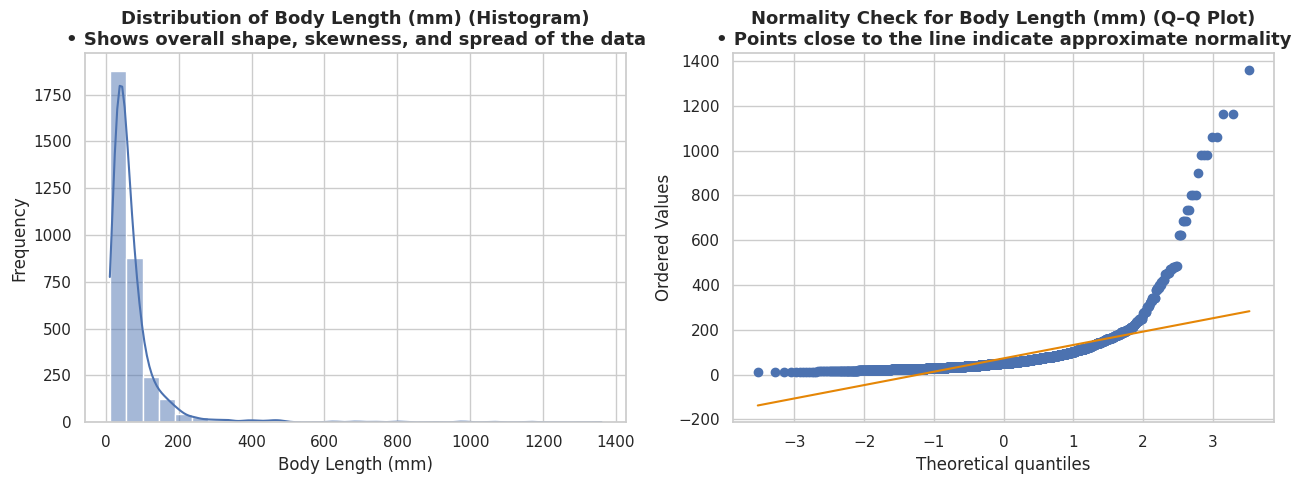

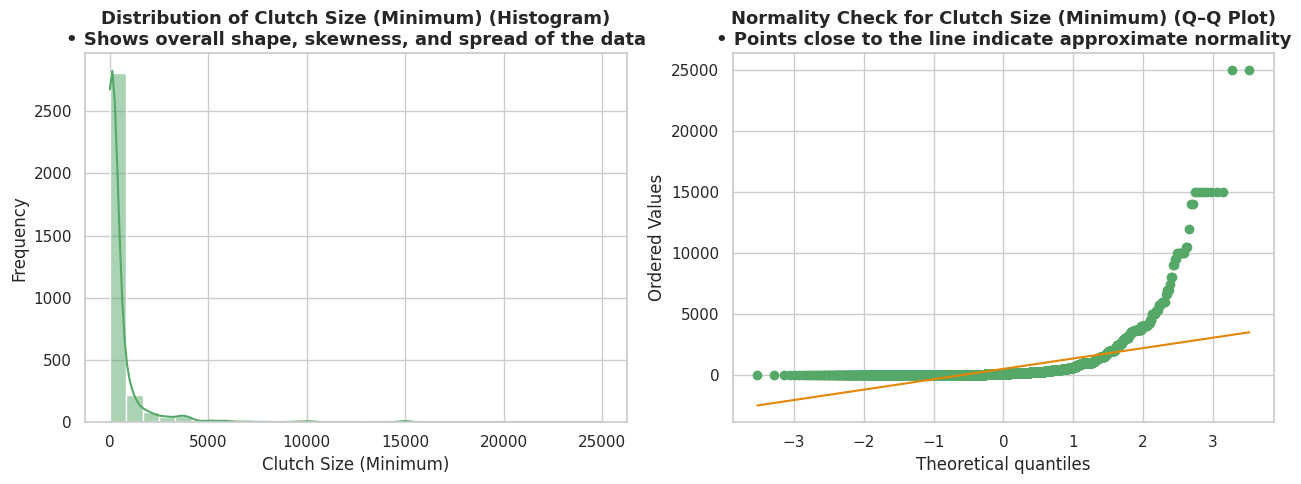

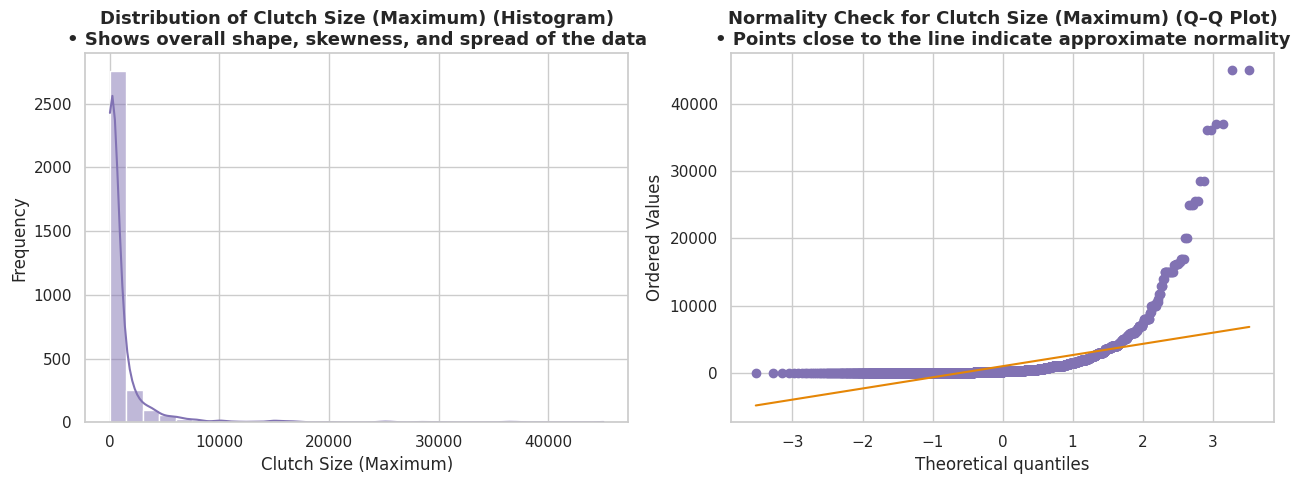

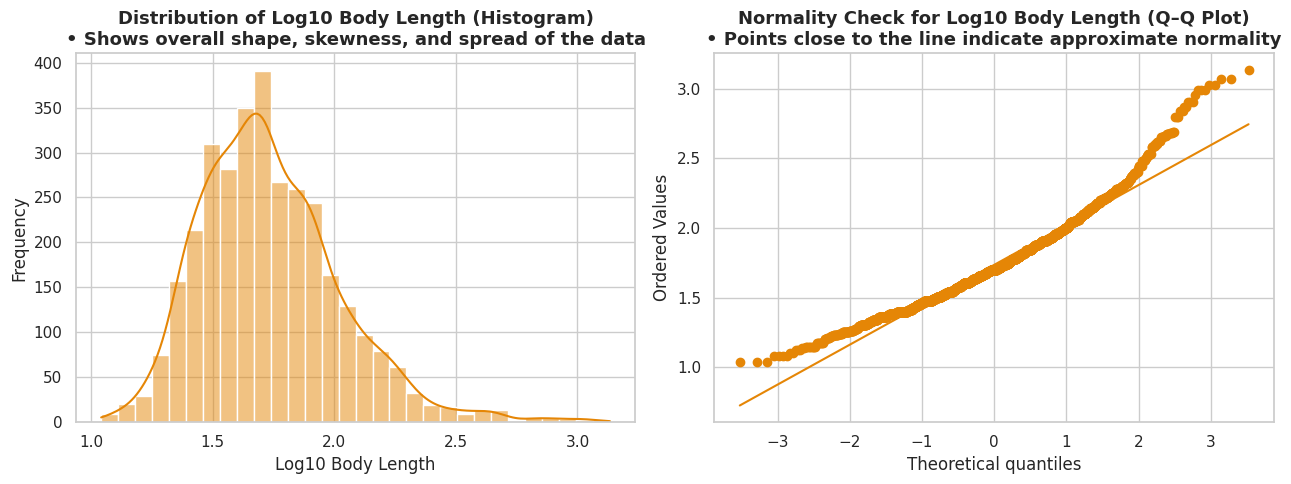

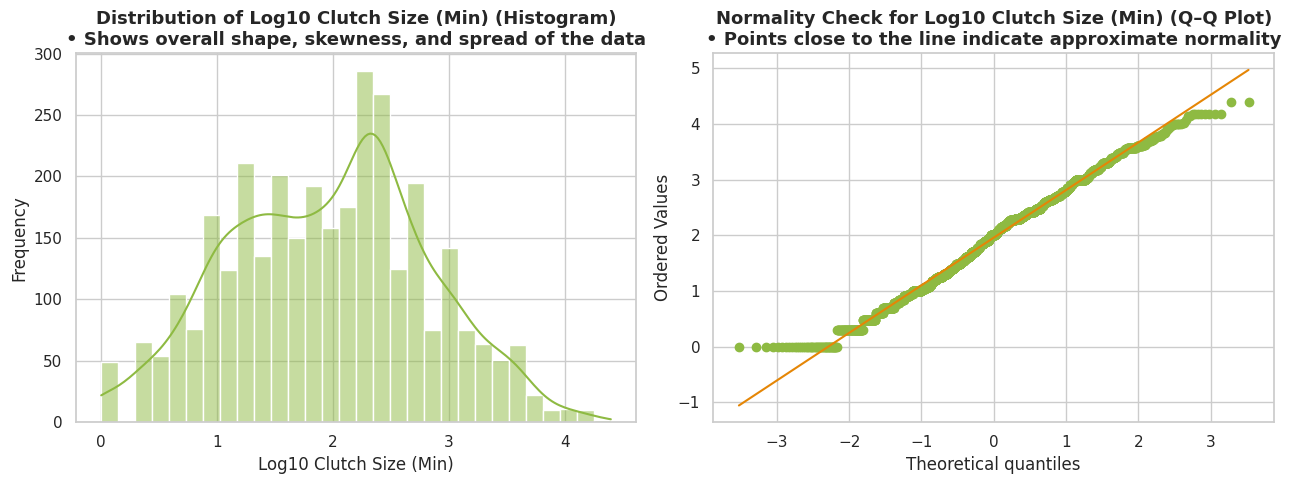

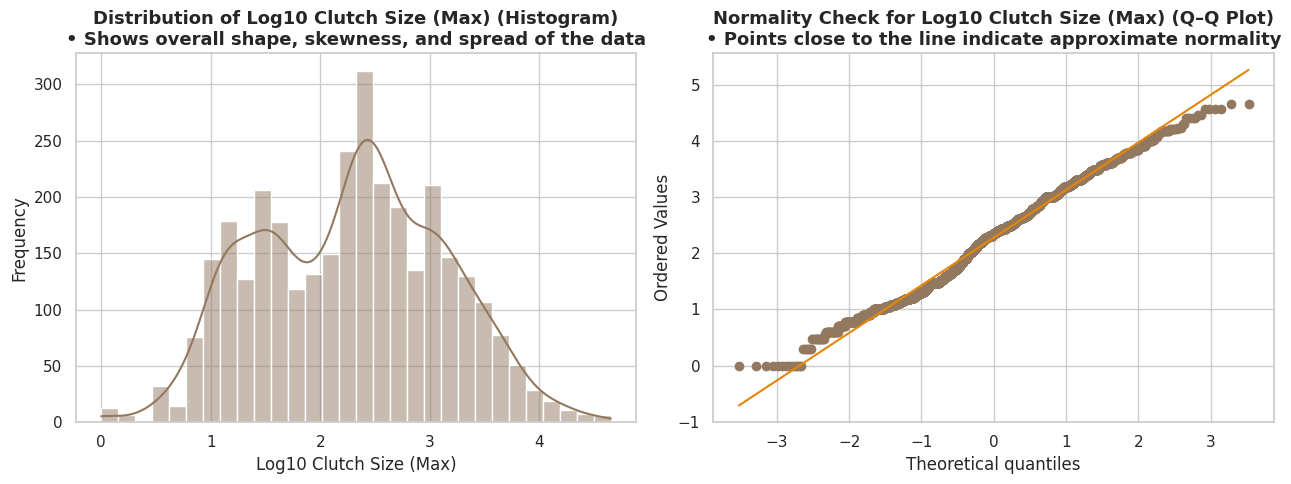

/tmp/ipython-input-2504936694.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


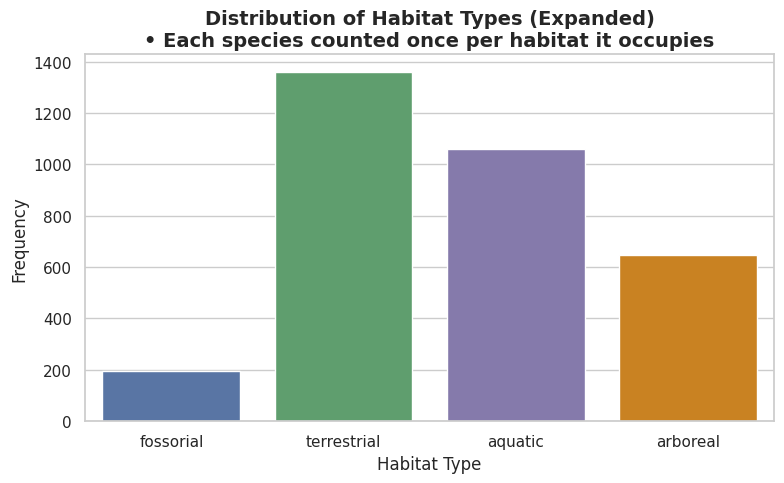

/tmp/ipython-input-2504936694.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-2504936694.py:104: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(


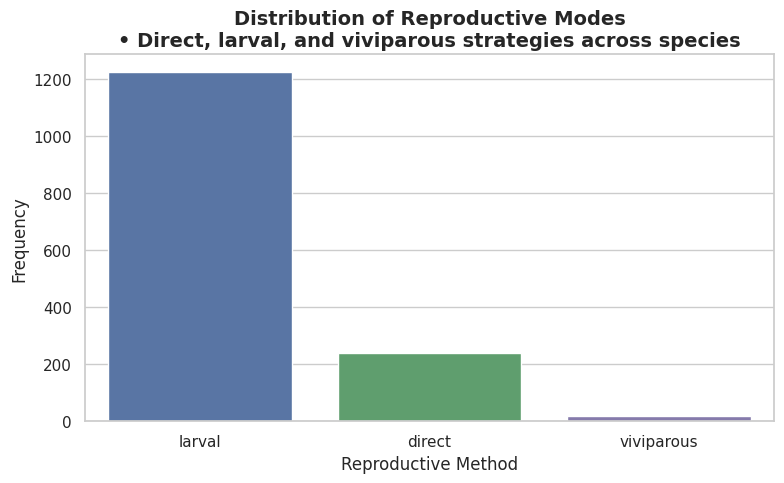

In [ ]:
"""
Visualizations using expanded habitats
"""

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set(style="whitegrid")

# preddy colors
palette_num = {
    "bodyLengthMm":      "#4C72B0",  #bluh
    "clutchSizeMinN":    "#55A868",  #grn
    "clutchSizeMaxN":    "#8172B3",  #plum
    "log_bodyLengthMm":  "#E58606",  #ambr
    "log_clutchSizeMinN":"#8EBA42",  #other grn
    "log_clutchSizeMaxN":"#937860"   #brn
}

palette_cat = ["#4C72B0", "#55A868", "#8172B3", "#E58606"]

# Helper: column title for charts
pretty_names = {
    "bodyLengthMm": "Body Length (mm)",
    "clutchSizeMinN": "Clutch Size (Minimum)",
    "clutchSizeMaxN": "Clutch Size (Maximum)",

    "log_bodyLengthMm": "Log10 Body Length",
    "log_clutchSizeMinN": "Log10 Clutch Size (Min)",
    "log_clutchSizeMaxN": "Log10 Clutch Size (Max)"
}

# NUMERIC DISTRBT (raw/log10)
for col in numeric_cols + transformed_cols:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Histogram Title
    hist_title = (
        f"Distribution of {pretty_names[col]} (Histogram)\n"
        "• Shows overall shape, skewness, and spread of the data"
    )

    # QQ Plot Title
    qq_title = (
        f"Normality Check for {pretty_names[col]} (Q–Q Plot)\n"
        "• Points close to the line indicate approximate normality"
    )

    # Histogram
    sns.histplot(
        data_expanded[col],
        bins=30, kde=True,
        color=palette_num.get(col, "#888888"),
        ax=axes[0]
    )
    axes[0].set_title(hist_title, fontsize=13, fontweight="bold")
    axes[0].set_xlabel(pretty_names[col])
    axes[0].set_ylabel("Frequency")

    # QQ Plot
    stats.probplot(data_expanded[col], dist="norm", plot=axes[1])
    axes[1].get_lines()[0].set_color(palette_num.get(col, "#888888"))   # data pts
    axes[1].get_lines()[1].set_color("#E58606")                        # line
    axes[1].set_title(qq_title, fontsize=13, fontweight="bold")

    plt.tight_layout()
    plt.show()

# CATEGORICAL DISTRBT
# Habitat from expdd rows with the splits
plt.figure(figsize=(8, 5))
sns.countplot(
    x=data_expanded["habitat_split"],
    order=["fossorial", "terrestrial", "aquatic", "arboreal"],
    palette=palette_cat
)
plt.title(
    "Distribution of Habitat Types (Expanded)\n"
    "• Each species counted once per habitat it occupies",
    fontsize=14, fontweight="bold"
)
plt.xlabel("Habitat Type")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Reproduction
plt.figure(figsize=(8, 5))
sns.countplot(
    x=data["reproductiveMethod"],
    palette=palette_cat
)
plt.title(
    "Distribution of Reproductive Modes\n"
    "• Direct, larval, and viviparous strategies across species",
    fontsize=14, fontweight="bold"
)
plt.xlabel("Reproductive Method")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
"""
ANOVA Assumption Testing
1. Shapiro–Wilk normality (raw y log)
2. Normality by habitattype
3. Equal variances test, includes skewness and kurtosis
"""

import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, skew, kurtosis

# Preddy names yet again
pretty_names = {
    "bodyLengthMm": "Body Length (mm)",
    "clutchSizeMinN": "Clutch Size (Minimum)",
    "clutchSizeMaxN": "Clutch Size (Maximum)",
    "log_bodyLengthMm": "Log10 Body Length",
    "log_clutchSizeMinN": "Log10 Clutch Size (Min)",
    "log_clutchSizeMaxN": "Log10 Clutch Size (Max)"
}

# Normality (raw y log) w/skew y kurtosis
overall_tests = []

for col in numeric_cols + transformed_cols:
    vals = data_expanded[col].dropna()

    if len(vals) >= 3:
        w, p = shapiro(vals)

        overall_tests.append({
            "Variable": pretty_names[col],
            "N": len(vals),
            "Skewness": round(skew(vals), 3),
            "Kurtosis": round(kurtosis(vals), 3),
            "Shapiro W": round(w, 4),
            "p-value": round(p, 6),
            "Normal?": "✓ Yes" if p > 0.05 else "✗ No"
        })

overall_df = pd.DataFrame(overall_tests)
print("Overall Normality (Raw & Log Transformed)")
display(overall_df)

print("\nInterpret:")
print("• p > 0.05 ⇒ fail to reject normality (distribution ≈ normal)")
print("• Highly skewed (> |1|) or heavy-tailed (kurtosis > |3|) ⇒ not normal")

# Normality by habitat Type
habitat_tests = []

for habitat, group in data_expanded.groupby("habitat_split"):
    for col in numeric_cols + transformed_cols:
        vals = group[col].dropna()

        if len(vals) >= 3:
            w, p = shapiro(vals)
            habitat_tests.append({
                "Habitat": habitat,
                "Variable": pretty_names[col],
                "N": len(vals),
                "Skewness": round(skew(vals), 3),
                "Kurtosis": round(kurtosis(vals), 3),
                "Shapiro W": round(w, 4),
                "p-value": round(p, 6),
                "Normal?": "✓ Yes" if p > 0.05 else "✗ No"
            })

habitat_df = pd.DataFrame(habitat_tests)
print("Normality Tests by Habitat Type")
display(habitat_df)

print("\nInterpret:")
print("• Habitat groups may differ in skew due to constraints")
print("• Small N(<20) makes Shapiro unreliable\n")

# Lev test for eq variance
lev_results = []

for col in numeric_cols + transformed_cols:
    groups = [
        g[col].dropna().values
        for _, g in data_expanded.groupby("habitat_split")
        if len(g[col].dropna()) >= 3
    ]

    if len(groups) > 1:
        stat, p = levene(*groups)
        lev_results.append({
            "Variable": pretty_names[col],
            "F-statistic": round(stat, 4),
            "p-value": round(p, 6),
            "Equal variances?": "Yes" if p > 0.05 else "No"
        })

lev_df = pd.DataFrame(lev_results)
print("Levene’s Test for Equality of Variance")
display(lev_df)

print("\nInterpret:")
print("• p > 0.05 =(ANOVA assumption met)")
print("• p ≤ 0.05 =(use Welch ANOVA or nonparametric tests)")


=== Overall Normality (Raw + Log Transformed) ===


,Variable,N,Skewness,Kurtosis,Shapiro W,p-value,Normal?
0,Body Length (mm),3261,6.684,64.191,0.4718,0.0,✗ No
1,Clutch Size (Minimum),3261,7.653,83.278,0.3390,0.0,✗ No
2,Clutch Size (Maximum),3261,7.816,84.476,0.3439,0.0,✗ No
3,Log10 Body Length,3261,0.863,1.485,0.9628,0.0,✗ No
4,Log10 Clutch Size (Min),3261,-0.019,-0.490,0.9929,0.0,✗ No
5,Log10 Clutch Size (Max),3261,-0.002,-0.617,0.9895,0.0,✗ No



Interpretation:
• p > 0.05 ⇒ fail to reject normality (distribution ≈ normal)
• Highly skewed (> |1|) or heavy-tailed (kurtosis > |3|) ⇒ not normal
• Log10 transforms should reduce skew but may not fully normalize biologically skewed traits

=== Normality Tests by Habitat Type (Expanded) ===


,Habitat,Variable,N,Skewness,Kurtosis,Shapiro W,p-value,Normal?
0,aquatic,Body Length (mm),1060,6.483,57.971,0.4681,0.000000,✗ No
1,aquatic,Clutch Size (Minimum),1060,7.990,87.765,0.3221,0.000000,✗ No
2,aquatic,Clutch Size (Maximum),1060,7.255,71.723,0.3538,0.000000,✗ No
3,aquatic,Log10 Body Length,1060,0.810,1.225,0.9656,0.000000,✗ No
4,aquatic,Log10 Clutch Size (Min),1060,0.012,-0.469,0.9937,0.000191,✗ No
5,aquatic,Log10 Clutch Size (Max),1060,0.024,-0.534,0.9908,0.000003,✗ No
6,arboreal,Body Length (mm),646,2.124,7.195,0.8312,0.000000,✗ No
7,arboreal,Clutch Size (Minimum),646,4.377,23.610,0.4883,0.000000,✗ No
8,arboreal,Clutch Size (Maximum),646,6.037,53.679,0.4668,0.000000,✗ No
9,arboreal,Log10 Body Length,646,0.315,-0.027,0.9916,0.001002,✗ No



Interpretation:
• Habitat groups may differ in skew due to ecological constraints
• Small N (<20) makes Shapiro unreliable — interpret cautiously

=== Levene’s Test (Homogeneity of Variance) ===


,Variable,F-statistic,p-value,Equal variances?
0,Body Length (mm),29.8984,0.000000,✗ No
1,Clutch Size (Minimum),4.7940,0.002462,✗ No
2,Clutch Size (Maximum),5.3430,0.001138,✗ No
3,Log10 Body Length,23.6996,0.000000,✗ No
4,Log10 Clutch Size (Min),5.8601,0.000548,✗ No
5,Log10 Clutch Size (Max),6.3165,0.000287,✗ No



Interpretation:
• p > 0.05 ⇒ equal variances across habitats (ANOVA assumption met)
• p ≤ 0.05 ⇒ variances differ (use Welch ANOVA or nonparametric tests)


In [ ]:
"""
Welch ANOVA Test Check
1. Normality is violated (YUP)
2. Variances are unequal (YUP)
3. Sample size per group > 3 (YUP)
4. Distributions not highly skewed (SHOULD BE YUP)
"""

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

welch_checks = []

# Habitat Type group
groups = {hab: g for hab, g in data_expanded.groupby("habitat_split")}

for col in transformed_cols:
    results = {"Variable": pretty_names[col]}

    # Sample size check
    ns = {hab: len(groups[hab][col].dropna()) for hab in groups}
    results["Small groups?"] = any(n < 3 for n in ns.values())
    results["Ns per habitat"] = ns

    # Skewness check (< ~2)
    skews = {hab: round(skew(groups[hab][col].dropna()), 3)
             for hab in groups if len(groups[hab][col].dropna()) >= 3}
    results["Skewness per habitat"] = skews
    results["High skew?"] = any(abs(s) > 2 for s in skews.values())

    # Variance inequality (is OK)
    vars_ = {hab: round(groups[hab][col].dropna().var(), 4)
             for hab in groups}
    results["Variances"] = vars_

    # Final Welch ANOVA
    if results["Small groups?"]:
        results["Welch OK?"] = "No (N<3)"
    elif results["High skew?"]:
        results["Welch OK?"] = "Maybe (Still high skew ugh"
    else:
        results["Welch OK?"] = "YUP!"

    welch_checks.append(results)

# Read better
welch_df = pd.DataFrame(welch_checks)

print("Welch ANOVA Assump Test")
display(welch_df)

print("\nINTERPRET:")
print("• Welch ANOVA DOES NOT need equal variances (Lev can be sig)")
print("• Normality NOT required for Welch when N is large")
print("• Skewness |value| < 2 is acceptable; > 2 is heavy tail")
print("• Any habitat group with N < 3 cannot be tested")
print("• Welch OK? will show YUP!, run Welch ANOVA.")


=== Welch ANOVA Validity Assessment ===


,Variable,Small groups?,Ns per habitat,Skewness per habitat,High skew?,Variances,Welch OK?
0,Log10 Body Length,False,"{'aquatic': 1060, 'arboreal': 646, 'fossorial'...","{'aquatic': 0.81, 'arboreal': 0.315, 'fossoria...",False,"{'aquatic': 0.0958, 'arboreal': 0.0443, 'fosso...",✓ Yes (Suitable for Welch’s ANOVA)
1,Log10 Clutch Size (Min),False,"{'aquatic': 1060, 'arboreal': 646, 'fossorial'...","{'aquatic': 0.012, 'arboreal': -0.256, 'fossor...",False,"{'aquatic': 0.7255, 'arboreal': 0.6145, 'fosso...",✓ Yes (Suitable for Welch’s ANOVA)
2,Log10 Clutch Size (Max),False,"{'aquatic': 1060, 'arboreal': 646, 'fossorial'...","{'aquatic': 0.024, 'arboreal': -0.207, 'fossor...",False,"{'aquatic': 0.6988, 'arboreal': 0.6175, 'fosso...",✓ Yes (Suitable for Welch’s ANOVA)



INTERPRETATION GUIDE:
• Welch ANOVA DOES NOT require equal variances (Levene can be significant).
• Normality is NOT required for Welch when N is moderately large.
• Skewness |value| < 2 is acceptable; > 2 suggests heavy tail.
• Any habitat group with N < 3 cannot be tested.
• If 'Welch OK?' shows ✓ Yes, you may run Welch ANOVA confidently.
